# Mapping and analyzing state data

This notebook reads `output/states`, merges that shapefile with the race and state-based overdose CSVs created by the previous notebooks, and then produces a number of choropleth maps.

In [1]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm

Set up fonts for matplot

In [2]:
# check for proxima nova extra bold
if os.path.isfile("../fonts/ProximaNova-Xbold-webfont.woff"):
    titlefont = fm.FontProperties(
        fname = "../fonts/ProximaNova-Xbold-webfont.woff",
        size = 36
    )
else:
    titlefont = fm.FontProperties(
        family = "Arial",
        size = 36
    )

## Load the data

In [3]:
states = gpd.read_file("../output/states")
states.head(1)

,id,properties,STUSAB,STATE_NAME,STATENS,geometry
0,05,,AR,Arkansas,00068085,"POLYGON ((558.8236946374037 261.0953220149457,..."


In [4]:
state_rates = (
    pd.read_csv(
        "../output/rates-by-state.csv",
        dtype = { "State Code": str }
    )
    .assign(
        pct_change = lambda x: (
            100 * (x["adj_rate_16"] - x["adj_rate_15"]) / 
            x["adj_rate_15"]
        )
    )
)
state_rates.head()

,State,State Code,drug,adj_rate_15,adj_rate_16,adj_rate_flag_15,adj_rate_flag_16,deaths_15,deaths_16,deaths_flag_15,...,population_15,population_16,upper_int_15,upper_int_16,gt_100_deaths,nonoverlapping_intervals,zscore,sig,quality_reporting,pct_change
0,Alabama,01,coc,0.83,1.78,NaN,NaN,38.0,82.0,NaN,...,4858979,4863300,1.14,2.22,False,True,4.099587,1.0,False,114.457831
1,Alaska,02,coc,NaN,NaN,Suppressed,Unreliable,NaN,15.0,Suppressed,...,738432,741894,NaN,3.04,False,False,NaN,NaN,True,NaN
2,Arizona,04,coc,0.94,1.22,NaN,NaN,62.0,82.0,NaN,...,6828065,6931071,1.22,1.52,False,False,1.579397,0.0,True,29.787234
3,Arkansas,05,coc,NaN,NaN,Unreliable,Unreliable,14.0,10.0,NaN,...,2978204,2988248,0.90,0.64,False,False,NaN,0.0,False,NaN
4,California,06,coc,0.72,0.86,NaN,NaN,296.0,366.0,NaN,...,39144818,39250017,0.80,0.95,True,False,2.204975,1.0,False,19.444444


## Set up mapping functions

In [5]:
def map_sig_states(drug, title):
    fig, ax = plt.subplots( figsize = (16, 9))

    ax.axis("equal")
    
    geo_df = (
        states
        .merge(
            state_rates.loc[lambda x: x["drug"] == drug],
            right_on = "State Code",
            left_on = "id"
        )
    )

    # map everything gray
    (
        geo_df
        .plot(
            color = "lightgray",
            edgecolor = "white",
            linewidth = 0.5,
            ax = ax
        )
    )

    # map the ones that do pass the test and color them blue
    (
        geo_df
        .loc[lambda x: x["quality_reporting"] == True]
        .loc[lambda x: x["sig"] == True]
        .plot(
            color = "darkblue",
            linewidth = 0.5,
            edgecolor = "white",
            alpha = 1,
            ax = ax
        )
    )

    ax.set_frame_on(False)
    ax.set_axis_off()
    ax.set_title(
        title,
        fontproperties = titlefont
    )
    return fig, ax

In [6]:
def map_choropleth(
    df, 
    col, 
    title,
    sig_only = False,
    flag_lower_quality = False,
    vmax = None,
    ):
    
    fig, ax = plt.subplots( figsize = (16, 9) )

    fig.set_facecolor("white")
    ax.axis("equal")
    ax.set_frame_on(False)
    
    geo_df = (
        states
        .merge(
            df,
            right_on = "State Code",
            left_on = "id"
        )
    )

    # Start with all states gray
    ax1 = (
        geo_df
        .plot(
            ax = ax,
            color = "lightgray",
            edgecolor = "white",
            linewidth = 0.5,
        )
    )

    ax2 = (
        geo_df
        .loc[lambda x: x[col].notnull()]
        .loc[lambda x: (sig_only == False) | (x["sig"] == True)]
        .plot(
            column = col,
            cmap = "Oranges",
            edgecolor = "black",
            linewidth = 0.50,
            vmin = 0,
            vmax = vmax,
            legend = True,
            ax = ax
        )
    )
    
    if flag_lower_quality:
        (
            geo_df
            .loc[lambda x: x[col].notnull()]
            .loc[lambda x: (sig_only == False) | (x["sig"] == True)]
            .loc[lambda x: x["quality_reporting"] == False]
            .plot(
                column = col,
                linewidth = 2,
                edgecolor = "blue",
                cmap = "Oranges",
                ax = ax
            )
        )
    
    ax.set_axis_off()

    ax.set_title(
        title, 
        fontproperties = titlefont
    )
        
    return fig, ax

# Cocaine deaths

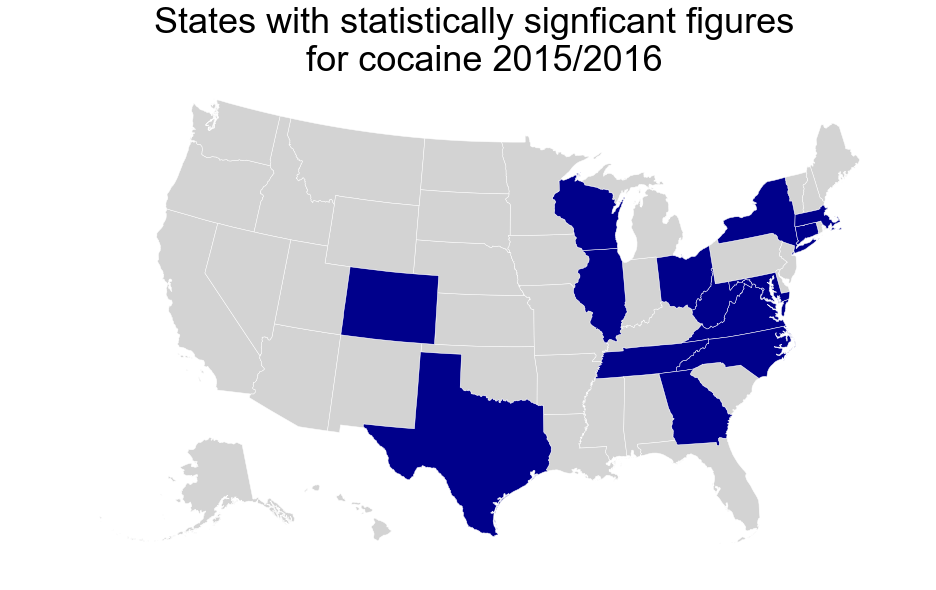

In [7]:
map_sig_states(
    "coc",
    "States with statistically signficant figures \n for cocaine 2015/2016"
);

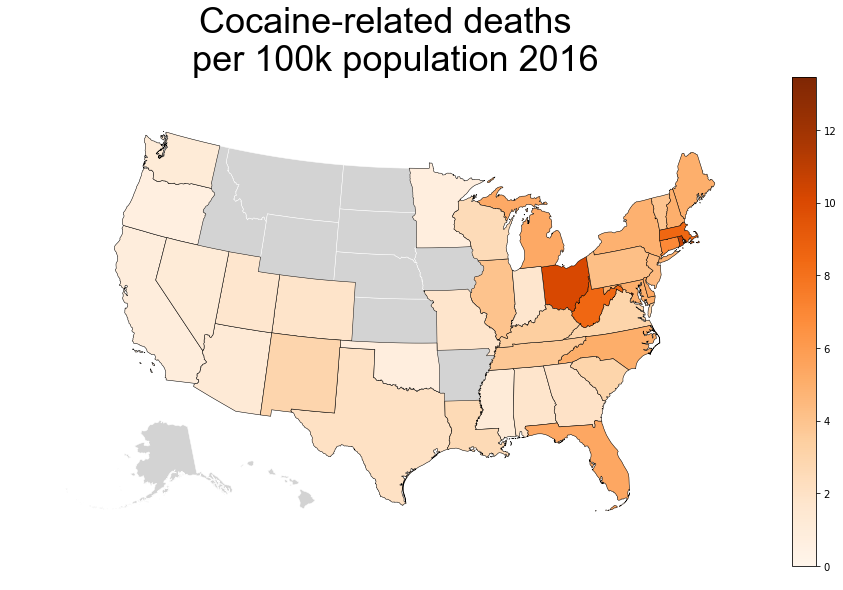

In [8]:
map_choropleth(
    state_rates.loc[lambda x: x["drug"] == "coc"],
    "adj_rate_16",
    "Cocaine-related deaths \n per 100k population 2016",
);


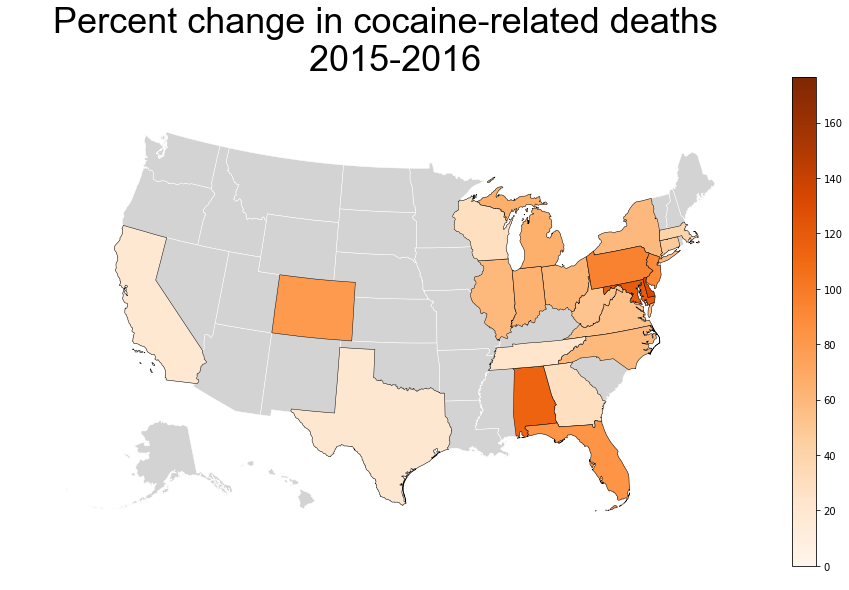

In [9]:
map_choropleth(
    state_rates.loc[lambda x: x["drug"] == "coc"],
    "pct_change",
    "Percent change in cocaine-related deaths \n 2015-2016",
    sig_only = True
);

Note, however, that states' drug-reporting quality varies. Here, we flag (in blue) the states that have not been identified as having high reporting quality:

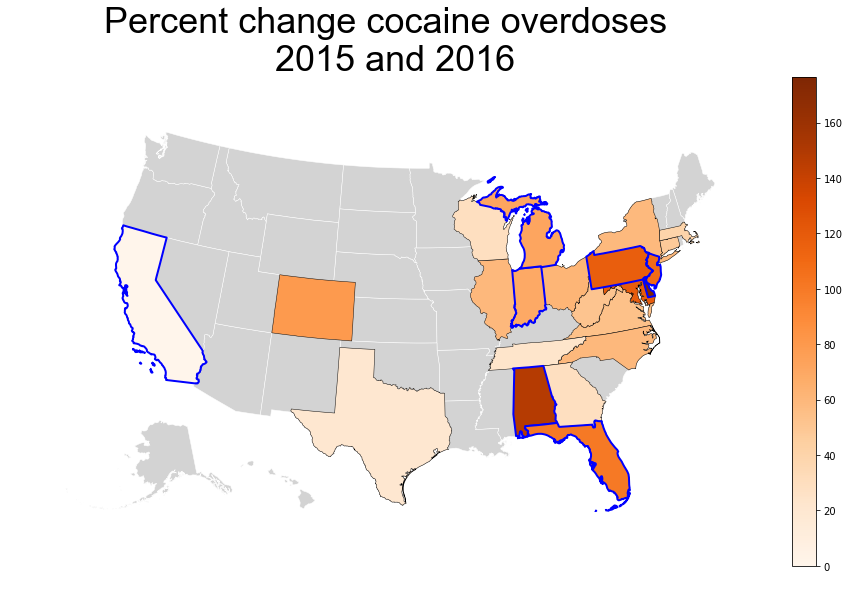

In [10]:
map_choropleth(
    state_rates.loc[lambda x: x["drug"] == "coc"],
    "pct_change",
    "Percent change cocaine overdoses \n 2015 and 2016",
    sig_only = True,
    flag_lower_quality = True
);

The states with statistically-signficant changes, ranked by percent change:

In [11]:
(
    state_rates
    .loc[lambda x: x["drug"] == "coc"]
    .loc[lambda x: x["sig"] == True]
    .sort_values("pct_change", ascending = False)
    [[ 
        "State",
        "drug",
        "adj_rate_15",
        "adj_rate_16",
        "pct_change",
        "quality_reporting"
    ]]
    .round(2)
    .reset_index(drop = True)
)

,State,drug,adj_rate_15,adj_rate_16,pct_change,quality_reporting
0,District of Columbia,coc,4.87,13.47,176.59,True
1,Delaware,coc,2.30,5.35,132.61,False
2,Maryland,coc,2.29,5.02,119.21,True
3,Alabama,coc,0.83,1.78,114.46,False
4,Pennsylvania,coc,2.16,4.21,94.91,False
5,New Jersey,coc,2.33,4.42,89.70,False
6,Florida,coc,2.93,5.38,83.62,False
7,Colorado,coc,1.04,1.87,79.81,True
8,Michigan,coc,3.20,5.30,65.62,False
9,Indiana,coc,1.05,1.72,63.81,False


# Cocaine + fentanyl deaths

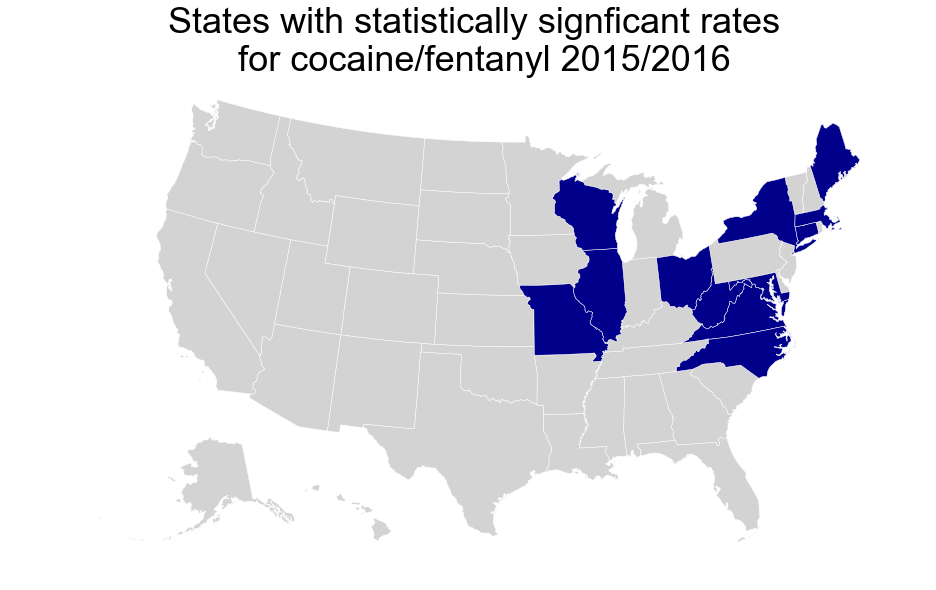

In [12]:
map_sig_states(
    "coc_fen",
    "States with statistically signficant rates \n for cocaine/fentanyl 2015/2016"
);

### States with suppressed cocaine+fentanyl rates in 2015 but not 2016

We cannot calculate year-over-year percent changes for these states, but some of them are indicating fast, large increases in cocaine/fentanyl deaths.

In [13]:
(
    state_rates
    .loc[lambda x: x["drug"] == "coc_fen"]
    .loc[lambda x: (
        x["adj_rate_flag_15"].notnull() & 
        x["adj_rate_flag_16"].isnull()
    )]
    .sort_values("adj_rate_16", ascending = False)
    [[
        "State",
        "quality_reporting",
        "adj_rate_15",
        "adj_rate_flag_15",
        "adj_rate_16",
        "adj_rate_flag_16",
    ]]
)

,State,quality_reporting,adj_rate_15,adj_rate_flag_15,adj_rate_16,adj_rate_flag_16
59,District of Columbia,True,NaN,Suppressed,6.38,NaN
70,Maine,True,NaN,Unreliable,3.32,NaN
51,Alabama,False,NaN,Suppressed,0.75,NaN
100,Wisconsin,True,NaN,Unreliable,0.73,NaN
65,Indiana,False,NaN,Suppressed,0.65,NaN
76,Missouri,True,NaN,Unreliable,0.61,NaN
55,California,False,NaN,Unreliable,0.11,NaN
94,Texas,True,NaN,Suppressed,0.11,NaN


# Fentanyl deaths as proportion of cocaine deaths

In [14]:
p_fen_in_coc_16 = (
    state_rates
    .set_index([ "State", "State Code", "quality_reporting", "drug"])
    ["deaths_16"]
    .unstack()
    .assign(
        p_fen_in_coc_16 = lambda x: (100 * x["coc_fen"] / x["coc"]).round(2),
    )
    .sort_values("p_fen_in_coc_16", ascending = False)
    .reset_index()
)

p_fen_in_coc_16

drug,State,State Code,quality_reporting,coc,coc_fen,p_fen_in_coc_16
0,New Hampshire,33,True,61.0,51.0,83.61
1,Massachusetts,25,True,567.0,399.0,70.37
2,Maine,23,True,61.0,39.0,63.93
3,Connecticut,09,True,237.0,128.0,54.01
4,Maryland,24,True,314.0,169.0,53.82
5,Ohio,39,True,1124.0,602.0,53.56
6,Pennsylvania,42,False,513.0,270.0,52.63
7,Michigan,26,False,500.0,260.0,52.00
8,Rhode Island,44,True,112.0,58.0,51.79
9,Virginia,51,True,254.0,130.0,51.18


In 2016, more than 80% of the deaths that involved cocaine also involved fentanyl. In 10 states, more than half of the deaths that involved cocaine involved fentanyl:

- New Hampshire
- Massachusetts
- Maine
- Connecticut
- Maryland
- Ohio
- Pennsylvania
- Michigan
- Rhode Island
- Virginia

In [15]:
(
    p_fen_in_coc_16
    .loc[lambda x: x["p_fen_in_coc_16"] > 50]
    .reset_index(drop = True)
)

drug,State,State Code,quality_reporting,coc,coc_fen,p_fen_in_coc_16
0,New Hampshire,33,True,61.0,51.0,83.61
1,Massachusetts,25,True,567.0,399.0,70.37
2,Maine,23,True,61.0,39.0,63.93
3,Connecticut,09,True,237.0,128.0,54.01
4,Maryland,24,True,314.0,169.0,53.82
5,Ohio,39,True,1124.0,602.0,53.56
6,Pennsylvania,42,False,513.0,270.0,52.63
7,Michigan,26,False,500.0,260.0,52.00
8,Rhode Island,44,True,112.0,58.0,51.79
9,Virginia,51,True,254.0,130.0,51.18


However, the CDC suggests we exclude  we should exclude the states which have a poor reporting record. So if we do that, we actually have 8 states where more than half of the deaths involved fentanyl.
- New Hampshire
- Massachusetts
- Maine
- Connecticut
- Maryland
- Ohio
- Rhode Island
- Virginia


In [16]:
(
    p_fen_in_coc_16
    .loc[lambda x: x["p_fen_in_coc_16"] > 50]
    .loc[lambda x: x["quality_reporting"] == True]
    .reset_index(drop = True)
)

drug,State,State Code,quality_reporting,coc,coc_fen,p_fen_in_coc_16
0,New Hampshire,33,True,61.0,51.0,83.61
1,Massachusetts,25,True,567.0,399.0,70.37
2,Maine,23,True,61.0,39.0,63.93
3,Connecticut,09,True,237.0,128.0,54.01
4,Maryland,24,True,314.0,169.0,53.82
5,Ohio,39,True,1124.0,602.0,53.56
6,Rhode Island,44,True,112.0,58.0,51.79
7,Virginia,51,True,254.0,130.0,51.18


Map all states on this measure:

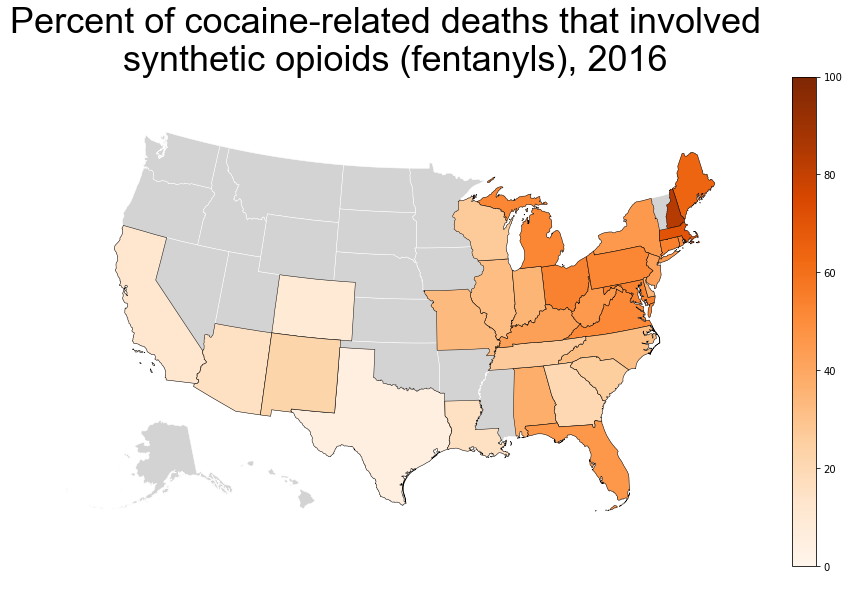

In [17]:
map_choropleth(
    p_fen_in_coc_16.assign(sig = None),
    "p_fen_in_coc_16",
    "Percent of cocaine-related deaths that involved \n synthetic opioids (fentanyls), 2016",
    vmax = 100,
);

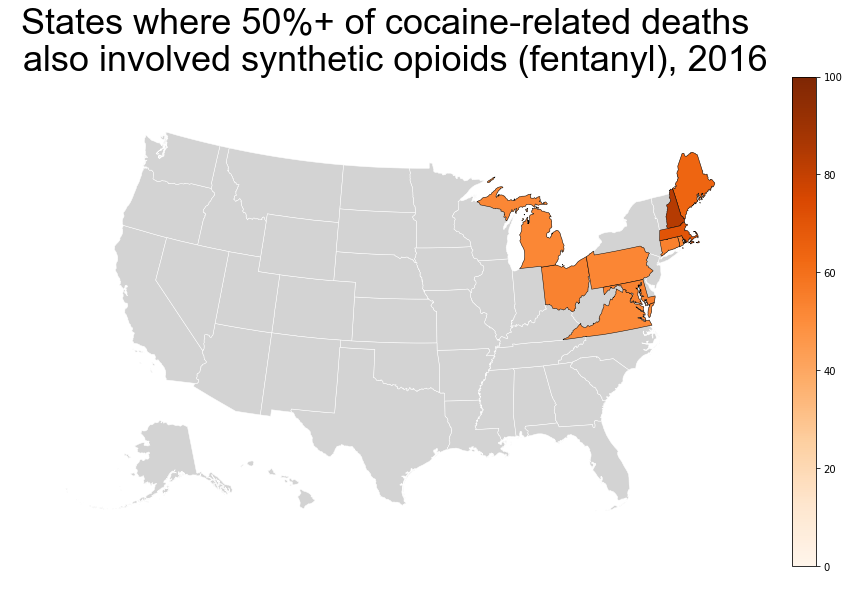

In [18]:
fig, ax = map_choropleth(
    (
        p_fen_in_coc_16
        .assign(sig = None)
        .assign(
            # Set everything smaller than 50 to null
            p_fen_in_coc_16 = lambda x: (
                (x["p_fen_in_coc_16"] > 50) * x["p_fen_in_coc_16"]
            ).replace(0, pd.np.nan)
        )
    ),
    "p_fen_in_coc_16",
    "States where 50%+ of cocaine-related deaths \n also involved synthetic opioids (fentanyl), 2016",
    vmax = 100,
)

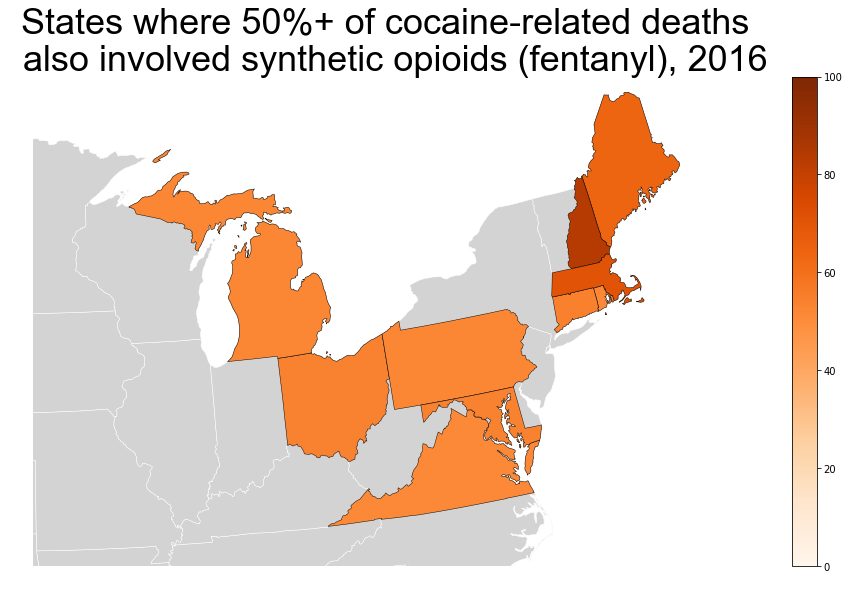

In [19]:
ax.set_xlim(600, 900)
ax.set_ylim(250, 575)
fig

## States with suppressed 2016 counts for cocaine+fentanyl but not for cocaine overall

In [20]:
states_suppressed_coc_fen_only = (
    state_rates
    .loc[lambda x: x["drug"].isin([ "coc_fen", "coc" ])]
    .set_index([ "State", "drug" ])
    [[ "deaths_flag_16", "deaths_16" ]]
    .unstack()
    .loc[lambda x: (
        x[("deaths_16", "coc_fen")].isnull() &
        x[("deaths_16", "coc")].notnull()
    )]
    .sort_values(("deaths_16", "coc"), ascending = False)
)

states_suppressed_coc_fen_only

deaths_flag_16             deaths_16        
drug                   coc     coc_fen       coc coc_fen
State                                                   
Washington             NaN  Suppressed      90.0     NaN
Utah                   NaN  Suppressed      48.0     NaN
Minnesota              NaN  Suppressed      43.0     NaN
Nevada                 NaN  Suppressed      37.0     NaN
Mississippi            NaN  Suppressed      33.0     NaN
Oklahoma               NaN  Suppressed      31.0     NaN
Oregon                 NaN  Suppressed      26.0     NaN
Vermont                NaN  Suppressed      21.0     NaN
Alaska                 NaN  Suppressed      15.0     NaN
Iowa                   NaN  Suppressed      15.0     NaN
Kansas                 NaN  Suppressed      13.0     NaN
Arkansas               NaN  Suppressed      10.0     NaN

---

---

---